# TP 2 Machine Learning: Detectando lugares del mundo

### Imports

In [1]:
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
import tensorflow as tf

print("Versión de tensorflow:{}".format(tf.__version__))
print("GPU:{}".format(tf.test.gpu_device_name()))


Versión de tensorflow:2.3.0
GPU:


### Analisis exploratorio de datos

Comenzamos con el análisis exploratorio de datos. Para esto, primero cargamos las imágenes y visualizamos su distribución y estructura. Vamos a usar las bibliotecas matplotlib, seaborn, y PIL para las visualizaciones. Creamos una funcion llamada data_processing.py con las funciones para cargar y procesar los datos

In [2]:
def load_image_paths(data_dir):
    """Carga las rutas de las imágenes en un diccionario por categoría."""
    categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    image_paths = {category: [] for category in categories}
    
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            image_paths[category].append(img_path)
    
    return image_paths

In [3]:
data_dir = 'data/train'  # Ruta al directorio de imagenes
image_paths = load_image_paths(data_dir)

#### Estructura y tipo de las imágenes
Muestra las dimensiones de algunas imágenes y calcula estadísticas de tamaño.

In [19]:
def image_size_statistics(image_paths):
    """Muestra las dimensiones de algunas imágenes y calcula estadísticas de tamaño."""
    sizes = []
    
    for category, paths in image_paths.items():
        for img_path in paths:
            img = Image.open(img_path)
            sizes.append(img.size)  # (width, height)
    
    widths, heights = zip(*sizes)
    
    print(f"Tamaño promedio: {sum(widths)/len(widths)}x{sum(heights)/len(heights)}")
    print(f"Tamaño máximo: {max(widths)}x{max(heights)}")
    print(f"Tamaño mínimo: {min(widths)}x{min(heights)}")
    
    return sizes

In [20]:
def plot_image_sizes(sizes):
    """Grafica la distribución de los tamaños de las imágenes."""
    widths, heights = zip(*sizes)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='skyblue')
    plt.title('Distribución de Ancho')
    plt.xlabel('Ancho (px)')
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='lightcoral')
    plt.title('Distribución de Alto')
    plt.xlabel('Alto (px)')
    
    plt.tight_layout()
    plt.show()

In [24]:
def show_random_images(image_paths, num_images=6):
    """Muestra imágenes aleatorias de cada categoría."""
    categories = list(image_paths.keys())
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for ax in axes:
        category = random.choice(categories)
        img_path = random.choice(image_paths[category])
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')
    
    plt.show()

Tamaño promedio: 150.0x149.90872167592988
Tamaño máximo: 150x150
Tamaño mínimo: 150x76


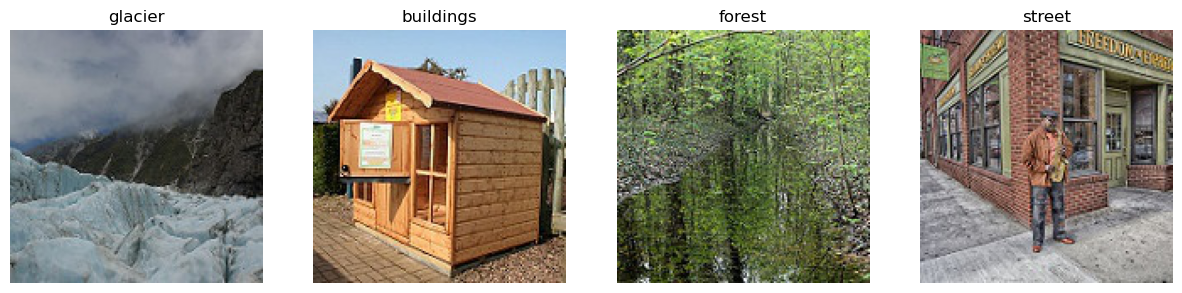

In [23]:
# Obtener estadísticas de tamaño de las imágenes
sizes = image_size_statistics(image_paths)

show_random_images(image_paths, num_images=4)  # Mostrar 4 imágenes aleatorias

#### Distribución de la variable a predecir
Visualizamos cómo se distribuyen las categorías en el conjunto de datos.

C:\Users\mtoma\AppData\Local\Temp\ipykernel_1604\973593326.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')


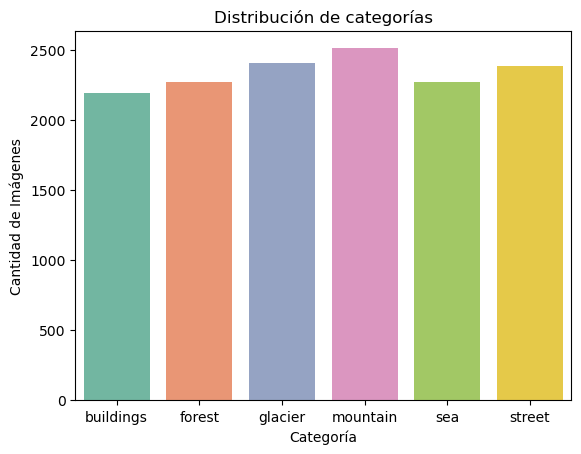

In [17]:
counts = {category: len(paths) for category, paths in image_paths.items()}
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Imágenes')
plt.title('Distribución de categorías')
plt.show()

#### Volumetria de los datos
Evaluamos el tipo de archivos que tenemos

In [26]:
def image_file_type_statistics(image_paths):
    """Obtiene el tipo de archivo de las imágenes y muestra estadísticas."""
    file_types = []
    
    for category, paths in image_paths.items():
        for img_path in paths:
            file_type = img_path.split('.')[-1]  # Obtiene la extensión del archivo
            file_types.append(file_type)
    
    file_type_counts = Counter(file_types)
    
    print("Distribución de tipos de archivo:")
    for file_type, count in file_type_counts.items():
        print(f"{file_type}: {count} imágenes")
    
    return file_type_counts

def plot_file_types(file_type_counts):
    """Grafica la distribución de tipos de archivo."""
    plt.bar(file_type_counts.keys(), file_type_counts.values(), color='lightgreen')
    plt.xlabel('Tipo de Archivo')
    plt.ylabel('Cantidad de Imágenes')
    plt.title('Distribución de Tipos de Archivo')
    plt.show()


Distribución de tipos de archivo:
jpg: 14034 imágenes


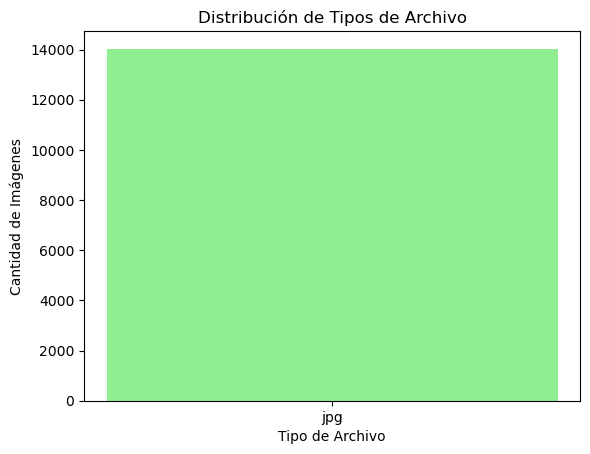

In [27]:
file_type_counts = image_file_type_statistics(image_paths)

# Graficar la distribución de los tipos de archivo
plot_file_types(file_type_counts)

### Modelado

#### Train Generator

In [4]:
data_dir_train = 'data/train'  # Ruta al directorio de imagenes
data_dir_test = 'data/test'  # Ruta al directorio de imagenes

In [5]:
# Definimos los parámetros para el generador de datos
img_width, img_height = 150, 150
batch_size = 32

# Configuramos el generador de imágenes para entrenamiento y test
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalizamos los valores de píxeles entre 0 y 1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Usamos un 20% del conjunto para validación
)

# Cargamos las imágenes y las etiquetas de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Usamos el subset de entrenamiento
)

# Cargamos las imágenes y las etiquetas de validación
validation_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Usamos el subset de validación
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


#### Modelado: MLP (Red Neuronal Multicapa)
En esta primera etapa, comenzamos con un modelo MLP simple. Dado que las imágenes son de tamaño 150x150, las cargaremos como vectores de 22,500 características (150\*150) para entrenar la red.
Este modelo servirá como punto de comparación inicial antes de probar arquitecturas más complejas, como redes convolucionales.

In [7]:
def create_mlp(input_shape, num_classes):
    """Crea un modelo MLP simple"""
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))  # Aplanar la imagen a un vector
    model.add(layers.Dense(128, activation='relu'))     # Capa completamente conectada
    model.add(layers.Dense(64, activation='relu'))      # Capa completamente conectada
    model.add(layers.Dense(num_classes, activation='softmax'))  # Capa de salida
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
# Definir parámetros
input_shape = (150, 150, 3)  # Imágenes 150x150 con 3 canales (RGB)
num_classes = 6              # Número de categorías a predecir

# Crear el modelo
mlp_model = create_mlp(input_shape, num_classes)

# Compilar el modelo
mlp_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Entrenar el modelo usando los generadores
history_mlp = mlp_model.fit(
    train_generator,              # Generador de imágenes de entrenamiento
    epochs=10,                    # Número de épocas
    validation_data=validation_generator,  # Generador de validación
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Número de batches por época
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Batches por época para validación
)


C:\Users\mtoma\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'train_generator' is not defined

#### Modelado: CNN (Red Neuronal Convolucional)
Luego de obtener resultados con el MLP, pasamos a una red convolucional, que es más adecuada para la clasificación de imágenes. Esta arquitectura emplea capas convolucionales que permiten detectar características visuales clave, como bordes y texturas.

In [8]:
def create_cnn(input_shape, num_classes):
    """Crea un modelo CNN básico"""
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Capa de salida
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [9]:
# Definir parámetros
input_shape = (150, 150, 3)  # Imágenes 150x150 con 3 canales (RGB)
num_classes = 6              # Número de categorías a predecir

# Crear el modelo CNN
cnn_model = create_cnn(input_shape, num_classes)

# Compilar el modelo
cnn_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Entrenar el modelo usando los generadores
history_cnn = cnn_model.fit(
    train_generator,              # Generador de imágenes de entrenamiento
    epochs=15,                    # Número de épocas (puedes ajustar según resultados)
    validation_data=validation_generator,  # Generador de validación
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Número de batches por época
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Batches por época para validación
)

C:\Users\mtoma\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 109s 303ms/step - accuracy: 0.5377 - loss: 1.1824 - val_accuracy: 0.7026 - val_loss: 0.7901
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.5625 - loss: 0.6808 - val_accuracy: 0.7000 - val_loss: 1.1262
Epoch 3/15


C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


350/350 ━━━━━━━━━━━━━━━━━━━━ 107s 304ms/step - accuracy: 0.7147 - loss: 0.7699 - val_accuracy: 0.7443 - val_loss: 0.7000
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.8125 - loss: 0.4204 - val_accuracy: 0.4500 - val_loss: 1.0571
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 107s 304ms/step - accuracy: 0.7589 - loss: 0.6584 - val_accuracy: 0.8035 - val_loss: 0.5781
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - accuracy: 0.8438 - loss: 0.4266 - val_accuracy: 0.7500 - val_loss: 0.6421
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 108s 308ms/step - accuracy: 0.7816 - loss: 0.5922 - val_accuracy: 0.8093 - val_loss: 0.5354
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.8125 - loss: 0.6823 - val_accuracy: 0.8000 - val_loss: 0.7498
Epoch 9/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 105s 300ms/step - accuracy: 0.8099 - loss: 0.5106 - val_accuracy: 0.7622 - val_loss: 0.6704
Epoch 10/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - accuracy: 0.8438 - loss: 0.6407 - va

In [12]:
# Guardar el modelo entrenado en un archivo
cnn_model.save('cnn_model.h5')
print("Modelo guardado en 'cnn_model.h5'")

Modelo guardado en 'cnn_model.h5'


#### Modelado: Transfer Learning
Para mejorar los resultados, probamos una técnica de transferencia de aprendizaje. Utilizamos un modelo preentrenado (por ejemplo, `VGG16`), que ya ha sido entrenado en grandes cantidades de datos, y lo ajustamos para nuestro conjunto de imágenes.


In [7]:
def create_transfer_model(input_shape, num_classes):
    """Crea un modelo utilizando VGG16 preentrenado"""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congelamos las capas del modelo base

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Capa de salida
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [9]:
import tensorflow as tf
print("GPUs disponibles:", len(tf.config.list_physical_devices('GPU')))


GPUs disponibles: 0


In [8]:
# Definir parámetros
input_shape = (150, 150, 3)  # Imágenes 150x150 con 3 canales (RGB)
num_classes = 6              # Número de categorías a predecir

# Crear el modelo de Transfer Learning
transfer_model = create_transfer_model(input_shape, num_classes)

# Compilar el modelo
transfer_model.compile(optimizer=Adam(learning_rate=0.0001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Entrenar el modelo utilizando los generadores
history_transfer = transfer_model.fit(
    train_generator,              # Generador de imágenes de entrenamiento
    epochs=15,                    # Número de épocas (puedes ajustar según resultados)
    validation_data=validation_generator,  # Generador de validación
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Batches por época
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Batches de validación por época
)

C:\Users\mtoma\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 57/350 ━━━━━━━━━━━━━━━━━━━━ 3:36 741ms/step - accuracy: 0.4248 - loss: 1.5049

KeyboardInterrupt: 

In [8]:
# Guardar el modelo entrenado en un archivo
transfer_model.save('tl_model.h5')
print("Modelo guardado en 'cnn_model.h5'")

Modelo guardado en 'cnn_model.h5'


#### Resultados y Conclusiones Parciales
En esta sección, presentamos los resultados obtenidos con cada arquitectura de red neuronal probada (MLP, CNN, y Transfer Learning). 
- **MLP**: 
- **CNN**: 
- **Transfer Learning**:

Se observa que la red convolucional (CNN) mejora considerablemente el rendimiento en comparación con el modelo MLP, lo que era esperable al tratarse de imágenes.


### Pruebas con el conjunto de test

In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Ruta de la carpeta de test
test_dir = 'data/test'

# Listar las clases (subcarpetas) en el conjunto de entrenamiento
class_names = sorted(os.listdir('data/train'))  # Usamos el directorio de entrenamiento para obtener los nombres de las clases

# Inicializar listas para los nombres de archivo y las predicciones
image_ids = []
predicted_labels = []

# Recorrer cada imagen en el directorio de test
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    
    # Cargar y preprocesar la imagen
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión para batch

    # Obtener la predicción de la clase
    prediction = cnn_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    
    # Almacenar el ID de la imagen y la predicción
    image_ids.append(img_file)
    predicted_labels.append(predicted_class)

# Crear un DataFrame con los resultados
submission_df = pd.DataFrame({
    'ID': image_ids,
    'Label': predicted_labels
})

# Guardar el DataFrame en un archivo CSV
submission_df.to_csv('submission.csv', index=False)

print("Archivo de submission generado: 'submission.csv'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Ruta de la carpeta de test
test_dir = 'data/test'

# Listar las clases (subcarpetas) en el conjunto de entrenamiento
class_names = sorted(os.listdir('data/train'))  # Usamos el directorio de entrenamiento para obtener los nombres de las clases

# Inicializar listas para los nombres de archivo y las predicciones
image_ids = []
predicted_labels = []

# Recorrer cada imagen en el directorio de test
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    
    # Cargar y preprocesar la imagen
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión para batch

    # Obtener la predicción de la clase
    prediction = transfer_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    
    # Almacenar el ID de la imagen y la predicción
    image_ids.append(img_file)
    predicted_labels.append(predicted_class)

# Crear un DataFrame con los resultados
submission_df = pd.DataFrame({
    'ID': image_ids,
    'Label': predicted_labels
})

# Guardar el DataFrame en un archivo CSV
submission_df.to_csv('submission_tl.csv', index=False)

print("Archivo de submission generado: 'submission.csv'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━